In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
# load modules
import torch
import torch.distributions as D
import pickle as pkl
import matplotlib.pyplot as plt
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import compute_variational_posterior

import math
%config InlineBackend.figure_format='retina'

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({'font.weight': 'normal'})
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth' : 2})

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [8]:
def create_blr_problem(dim, seed):
    if dim == 2:
        signal_std = 1e-2
    else:
        signal_std = 1e-1
    prior_alpha = 1
    num_training = dim
    torch.set_default_tensor_type(torch.DoubleTensor)
    blr = BayesLinRegressor(prior_mean=torch.zeros(dim),
                            prior_alpha=prior_alpha,
                            signal_std=signal_std,
                            num_targets=2 * num_training,
                            seed=seed,
                            num_train_points=num_training)
    blr.sample_feature_inputs()
    blr.sample_regression_targets()
    blr.posterior_update()
    target = blr.weight_posterior
    return blr, target

In [9]:
def compute_preds(d, blr_obj, training_data=False):
    preds = torch.zeros([0])
    sample_list = torch.tensor(d['compressed_samples'])
    for s in sample_list:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [10]:
def true_preds(blr_obj, training_data=False, seed=0):
    torch.manual_seed(seed)
    samples = blr_obj.weight_posterior.sample((500,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [11]:
def var_approx_preds(blr_obj, training_data=False, seed=0):
    torch.manual_seed(seed)
    samples = compute_variational_posterior(blr_obj.weight_posterior).sample((500,))
    preds = torch.zeros([0])
    for s in samples:
        preds = torch.cat((preds, blr_obj.empirical_prediction(s, training_data=training_data)[None]))
    return preds

In [12]:
def compute_log_prob_empirical_mog(full_preds, blr):
    normal_dists = D.normal.Normal(loc=full_preds, scale = signal_std)
    log_probs = normal_dists.log_prob(blr.regression_targets_test)
    sum_of_probs = torch.logsumexp(log_probs, dim=1)
    normalisation_constant = torch.log(torch.tensor(full_preds.shape[1]))
    gmm_log_prob_per_point = sum_of_probs - normalisation_constant
    gmm_log_prob = torch.sum(gmm_log_prob_per_point, dim=1)
    return gmm_log_prob

In [13]:
def make_gmm(preds, signal_std):
    mix = D.Categorical(torch.ones(preds.shape[1]))
    comp = D.Normal(loc=preds.permute(0, 2, 1), scale=b.signal_std)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

In [14]:
def compute_gaussian_likelihood(preds, y, b):
    # make normal using preds and signal noise
    m = preds.mean(1).to('cpu')
    s_al = (preds.var(1).to('cpu') + b.signal_std ** 2) ** 0.5
    
    return D.Normal(loc=m, scale=s_al).log_prob(y).sum(1)

In [15]:
def compute_expected_coding_efficiency(kl, epsilon=0.2):
    K = (1 + epsilon) * kl
    return K + torch.log(K + 1) + 1

In [16]:

from tqdm.notebook import tqdm
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.beamsearch.Coders.Encoder import Encoder as Empirical_Encoder
from models.SimpleBayesianLinRegressor import BayesLinRegressor
from rec.utils import kl_estimate_with_mc, plot_samples_in_2d, plot_running_sum_2d, plot_pairs_of_samples, compute_variational_posterior
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser

In [18]:
dim = 10
eps = 0.1
beamwidth = 5
b, t = create_blr_problem(dim, 1)

# Empirical Trajectory

In [19]:
def encode_sample(target, omega=5, epsilon=0.,
                  n_empirical_samples=10, seed=10, beamwidth=1, optimising_vars=False, aux_vars=None, dont_run=False):
    
    encoder = Empirical_Encoder(target,
                                seed,
                                CodingSampler,
                                GreedySampler,
                                EmpiricalMixturePosterior,
                                omega,
                                n_empirical_samples,
                                epsilon=epsilon,
                                beamwidth=beamwidth
                                )
    if aux_vars is not None:
        encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    if dont_run:
        return encoder
    else:
        return encoder, *encoder.run_encoder()

In [20]:
pckled_stuff = pkl.load(open(f"PickledStuff/BLR_RESULTS_v2/Dim{dim}/Empirical_Epsilon{eps}_Beam{beamwidth}_Omega5.pkl", "rb"))

In [21]:
aux_vars = pckled_stuff['aux_vars']

In [22]:
enc, z, idx = encode_sample(t, aux_vars=aux_vars, epsilon=eps, beamwidth=10)

/scratch/km817/miniconda3/envs/Torch/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [32]:
def plot_traj(target, prior, aux_samples, num_samples=1000, num_weights=5):
    samples = target.sample((num_samples,))
    running_sum = torch.cumsum(aux_samples, dim=0)
    final_sample = running_sum[-1]
    f, ax = plt.subplots(num_weights, num_weights, figsize=(3*num_weights, 3*num_weights), sharex=True, sharey=True)
    for i in range(num_weights):
        for j in range(num_weights):
            if i!=j:
                ax[i, j].plot(samples[:, i], samples[:, j], 'x')
                ax[i, j].plot(running_sum[:, i], running_sum[:, j], 'o-')
                ax[i, j].plot(final_sample[i], final_sample[j], 'ko')
            if i == num_weights - 1:
                ax[i, j].set_xlabel(f'$\mathbf{{w}}_{{{j+1}}}$')
            if j == 0:
                ax[i, j].set_ylabel(f'$\mathbf{{w}}_{{{i+1}}}$')
    f.tight_layout()

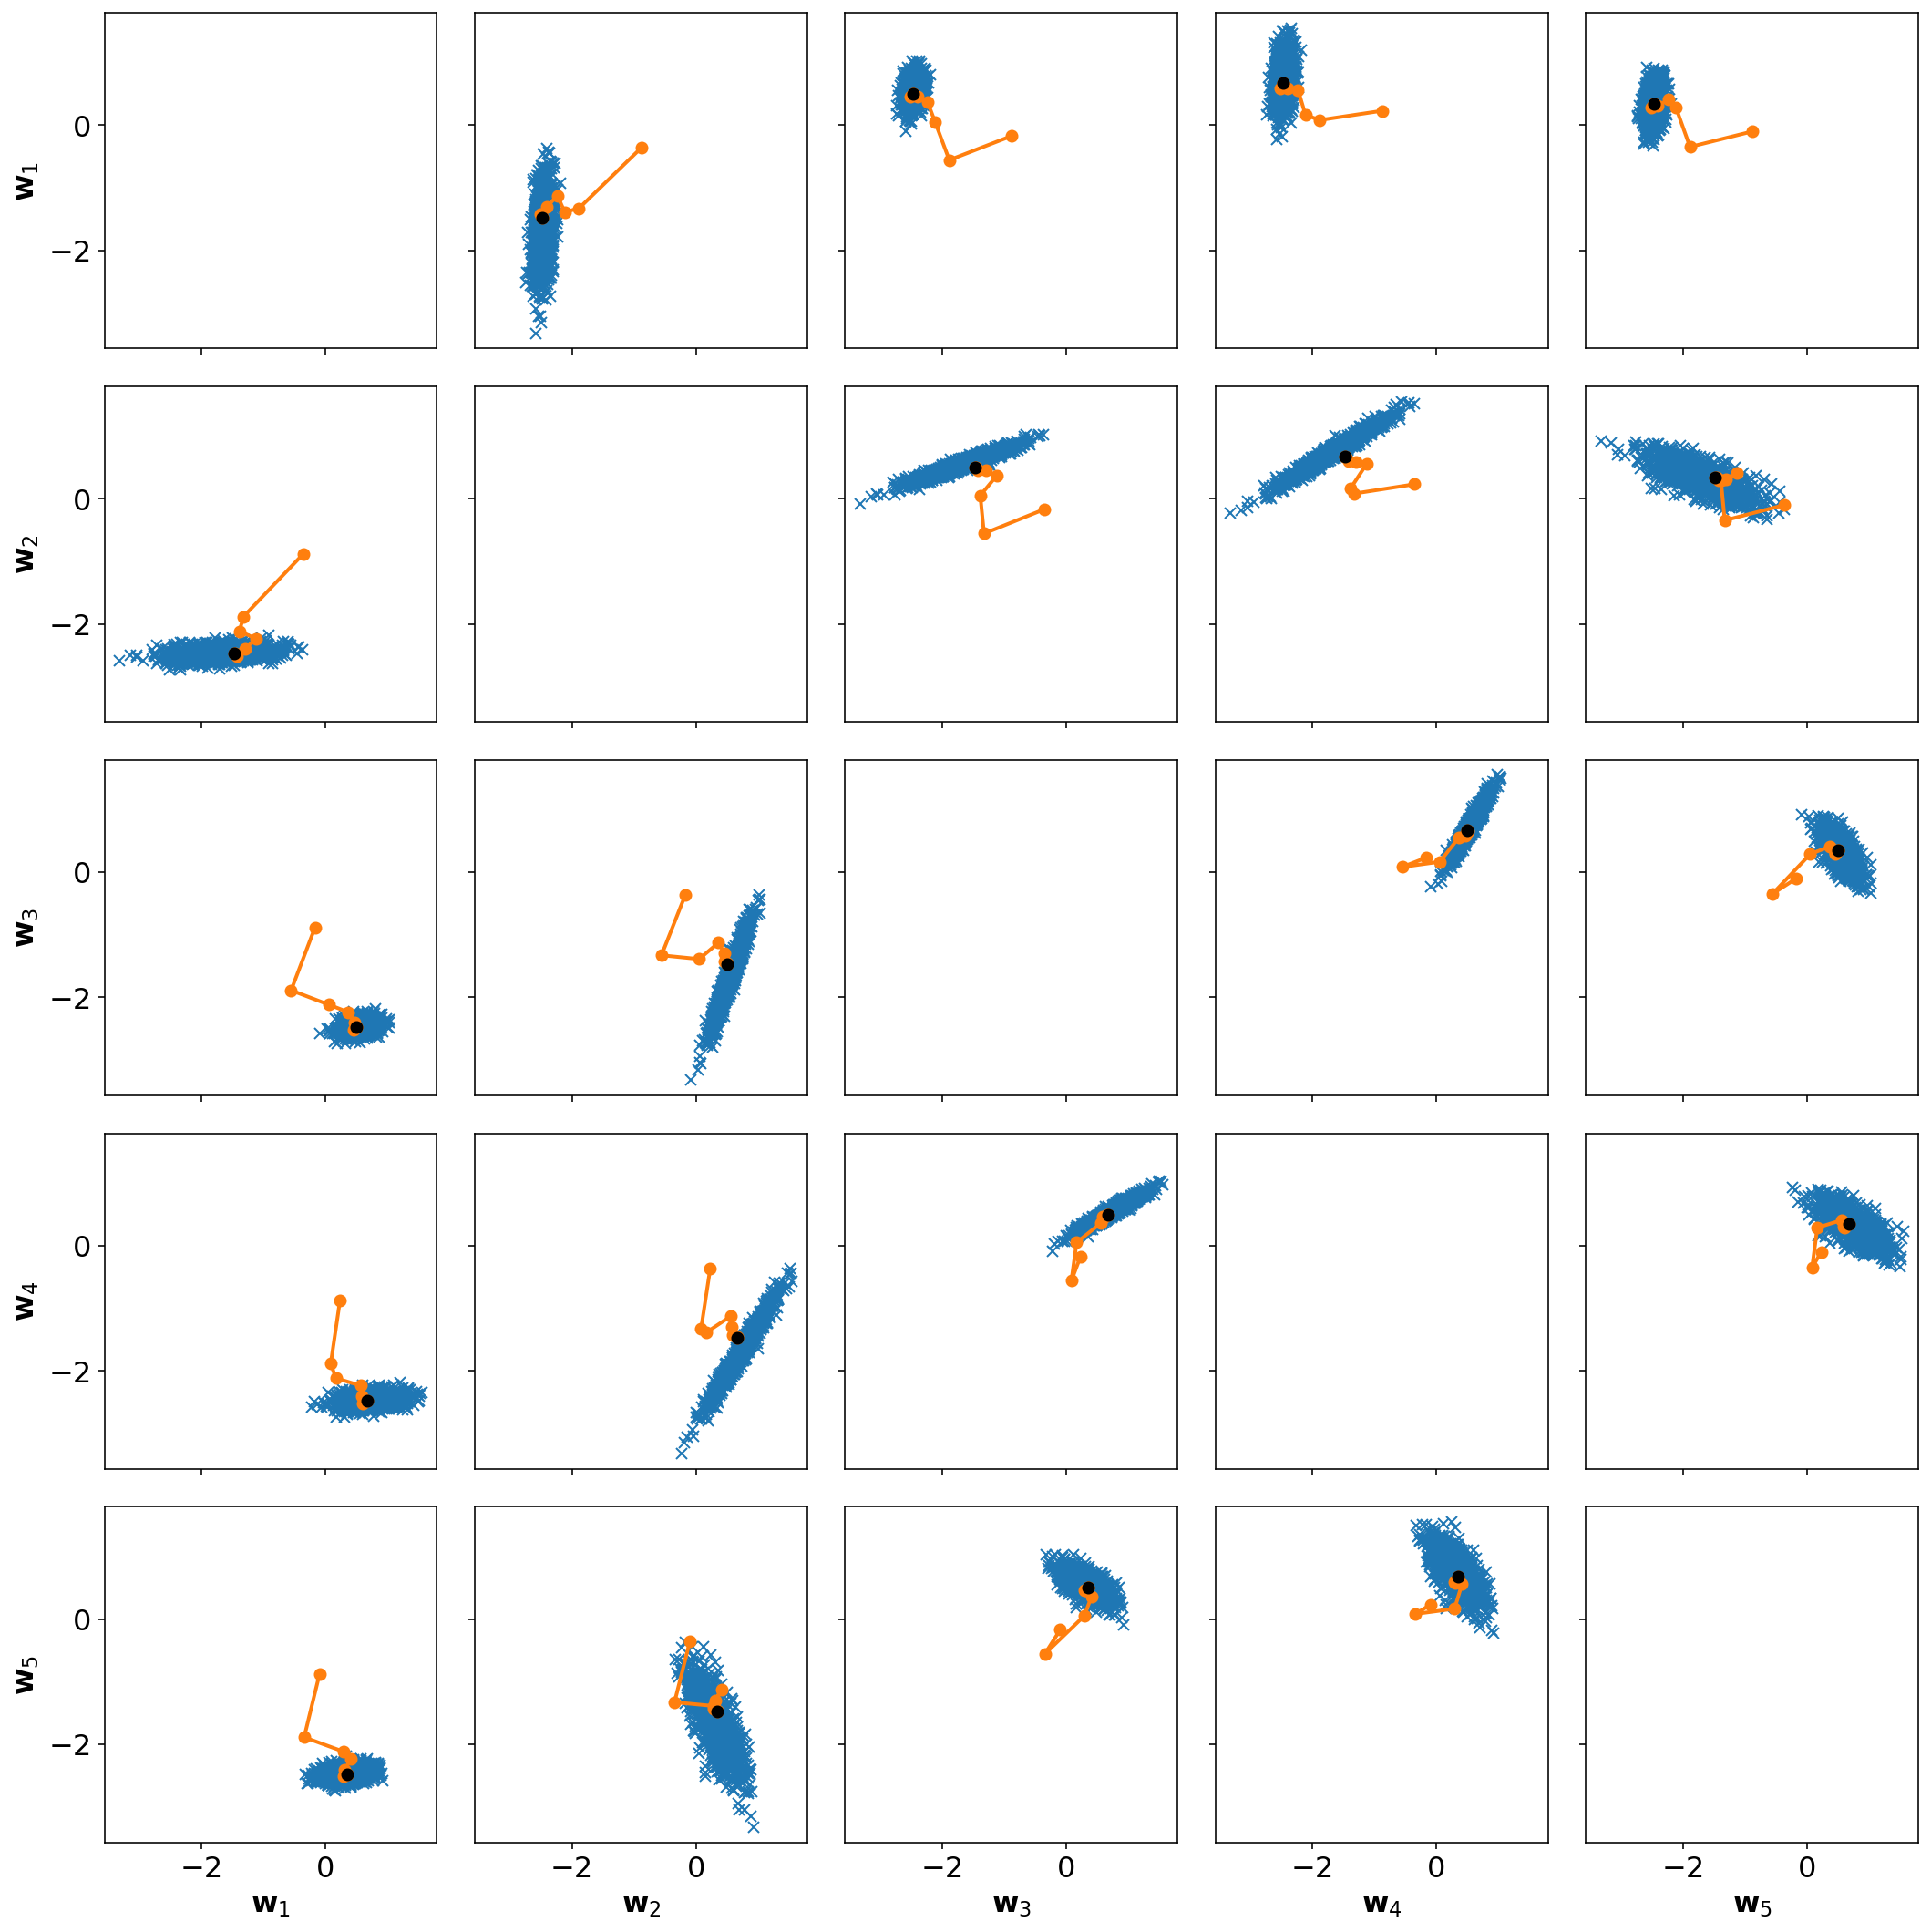

In [39]:
plot_traj(t, b, enc.selected_samples[0])
plt.savefig(f"Figures/Thesis/emp_blr{dim}_eps{eps}_traj_subset.pdf", bbox_inches='tight')

# Variational Trajectories

In [40]:
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.Coders.Encoder_Variational import Encoder as Variational_Encoder

In [41]:
def encode_sample_var(target, omega=5, epsilon=0.,
                  n_empirical_samples=10, seed=10, beamwidth=1, optimising_vars=False, aux_vars=None, dont_run=False):
    
    target = compute_variational_posterior(target)
    encoder = Variational_Encoder(target,
                                  seed,
                                  CodingSampler,
                                  GreedySampler,
                                  VariationalPosterior,
                                  omega,
                                  epsilon=epsilon,
                                  beamwidth=beamwidth
                                  )
    if aux_vars is not None:
        encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    
    if dont_run:
        return encoder
    else:
        return encoder, *encoder.run_encoder()

In [42]:
pckled_stuff_var = pkl.load(open(f"PickledStuff/BLR_RESULTS_v2/Dim{dim}/Variational_Epsilon{eps}_Beam{beamwidth}_Omega5.pkl", "rb"))

In [43]:
aux_vars_var = pckled_stuff_var['aux_vars']

In [44]:
enc, z, idx = encode_sample_var(t, aux_vars=aux_vars_var, epsilon=eps, beamwidth=10)

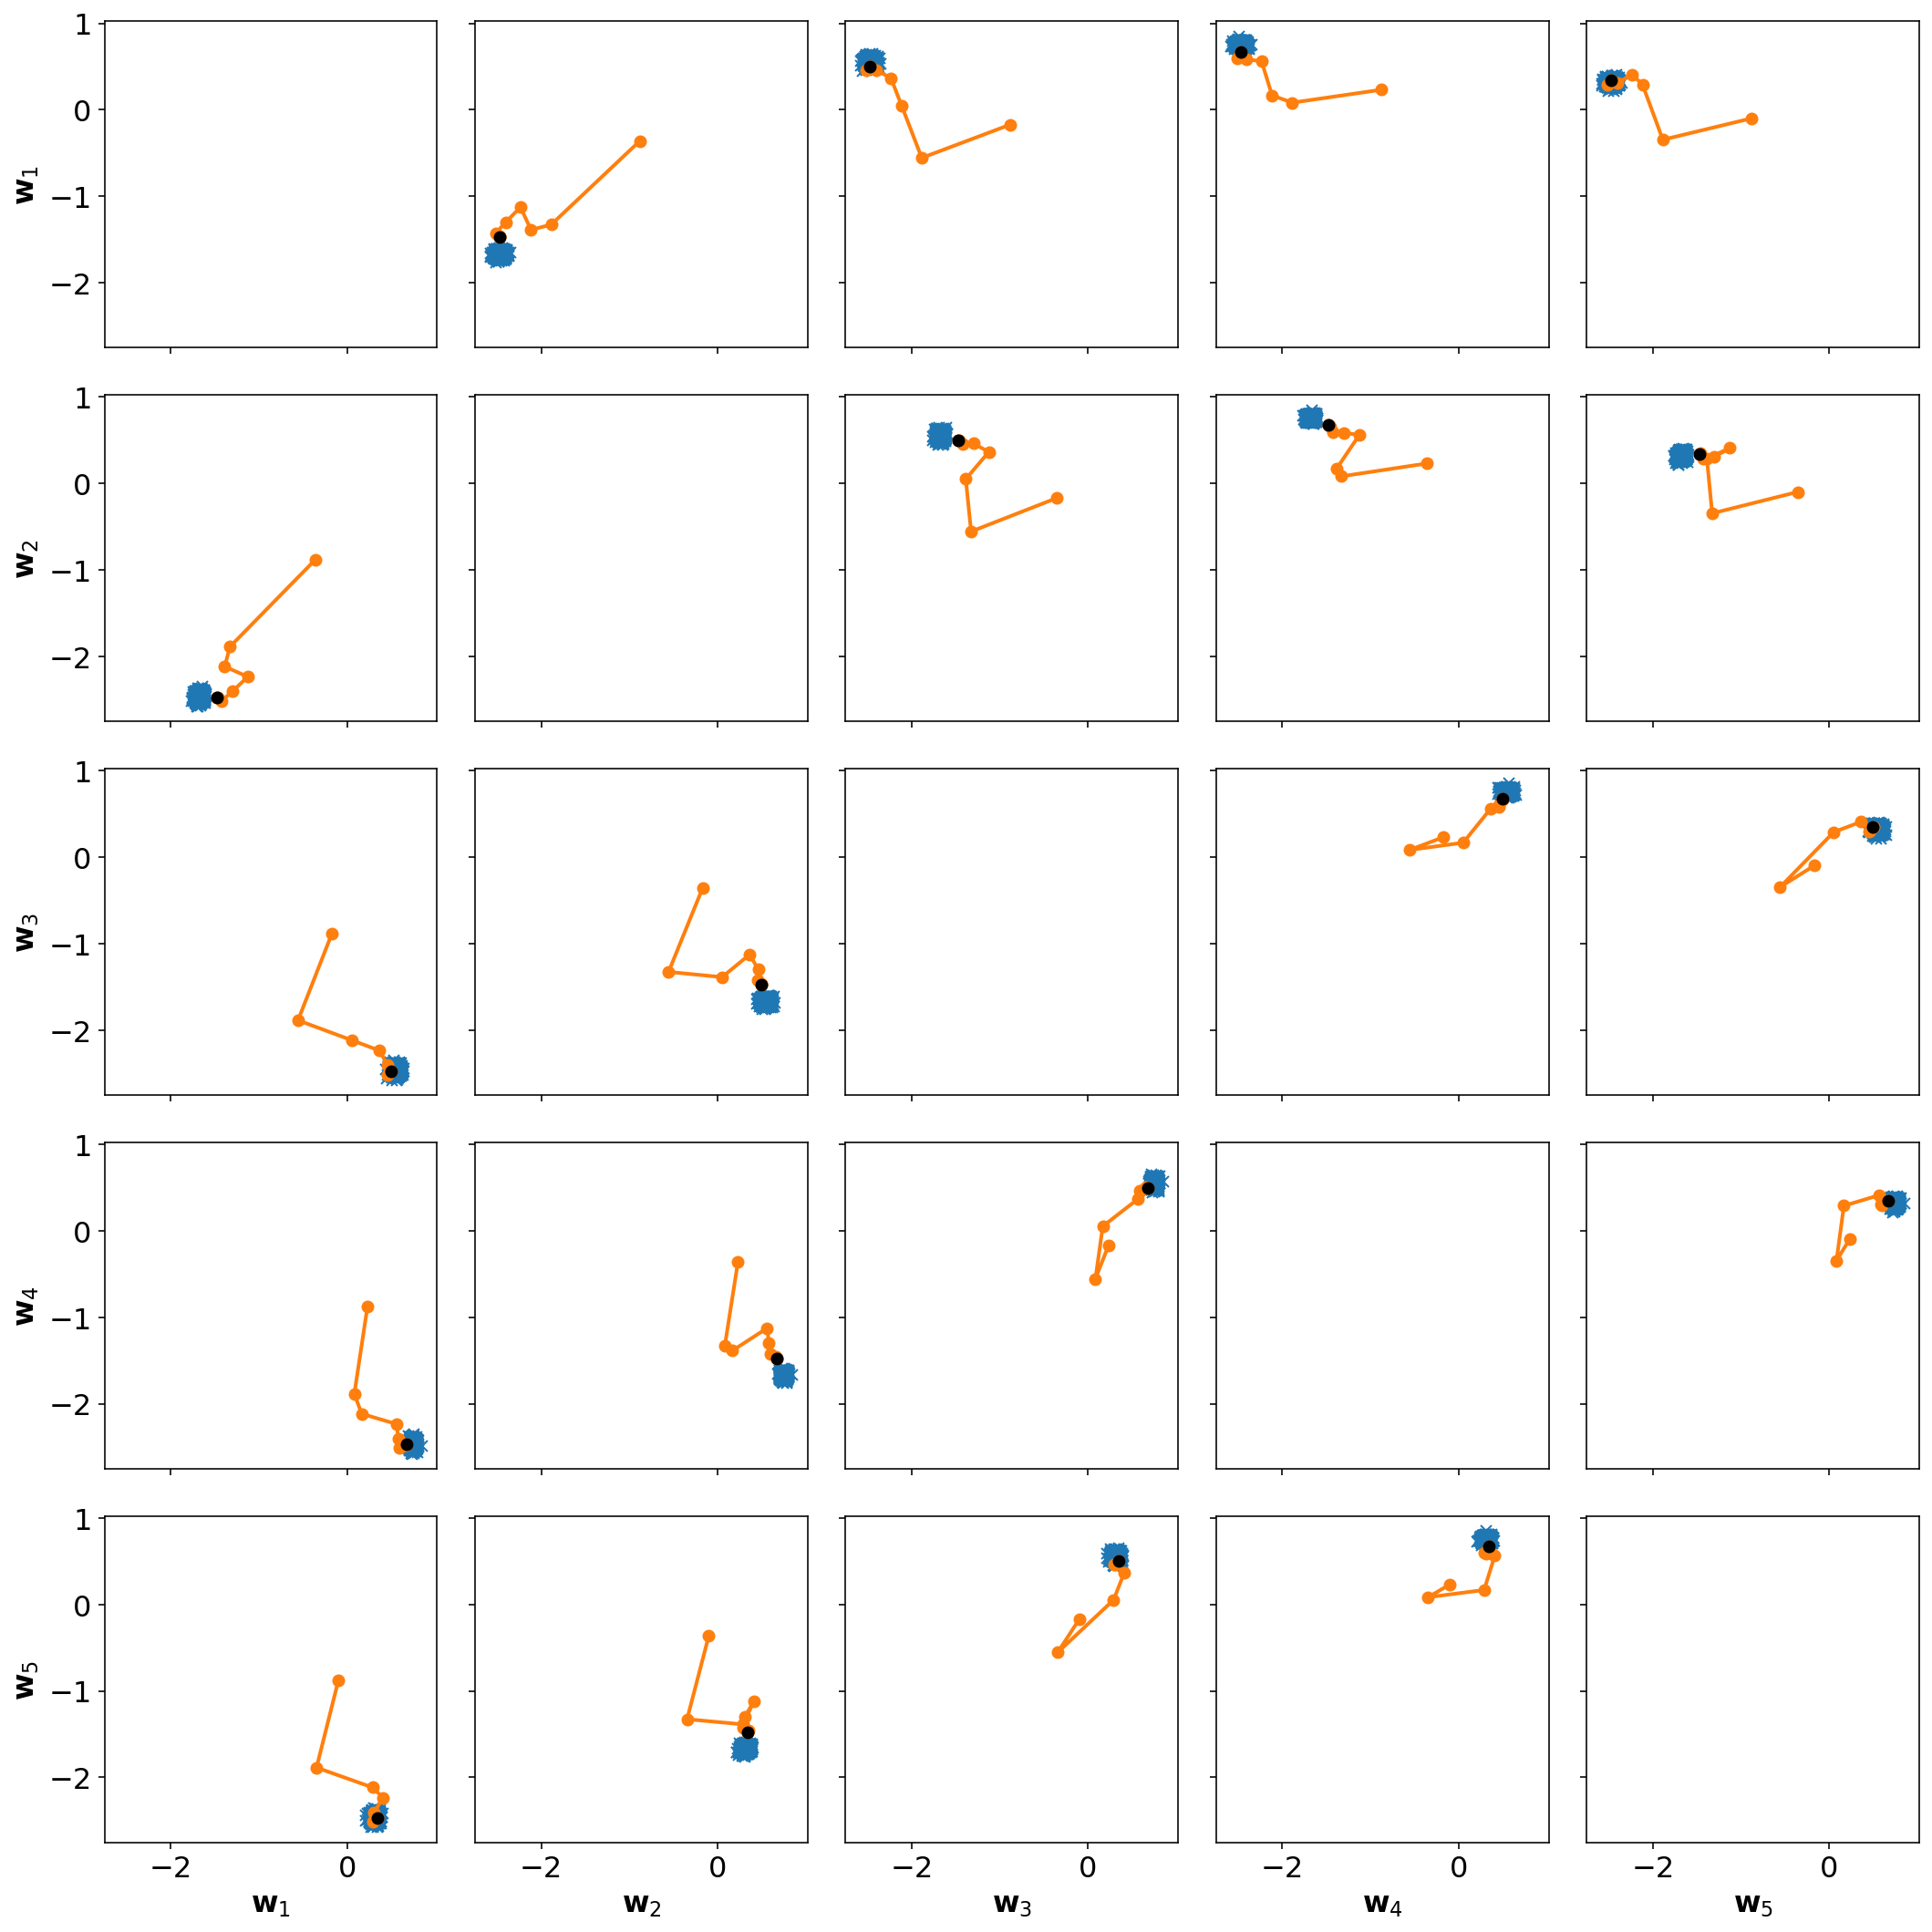

In [45]:
plot_traj(compute_variational_posterior(t), b, enc.selected_samples[0])
plt.savefig(f"Figures/Thesis/var_blr{dim}_eps{eps}_traj_subset.pdf", bbox_inches='tight')